# Investigation of the feasibility of urban building height analysis using remote sensing

## Datasets

Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A

Plateau by MILT dataset

### Library Imports

In [34]:
import ee
import geemap
from osgeo import gdal
import matplotlib.pyplot as plt
import math
import gdown
import cv2
import numpy as np
from datetime import datetime

import geopandas
import subprocess
import os
from shapely.geometry import Polygon
from scipy.ndimage import rotate


import rasterio as rio
import pyproj

In [2]:
# Authenticate if required
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
# Import submodule
import dl_sentinel as ds



In [177]:
def getCoordinates(geo_transform, col_index, row_index):
    """
    Returns the coordinates given the pixel position in the array
    """
    # print(geo_transform)
    px = geo_transform[0]
    py = geo_transform[3]
    rx = geo_transform[1]
    ry = geo_transform[5]
    x = px + col_index*rx
    y = py + row_index*ry # ry is negative
    return x, y

def getPixel(geo_transform, x,  y):
    """
    Returns the indices of the pixels given the coordinates in the array
    """
    # print(geo_transform)
    px = geo_transform[0]
    py = geo_transform[3]
    rx = geo_transform[1]
    ry = geo_transform[5]
    col_index = (x - px) / rx
    row_index = (y - py) / ry
    # Compared to int(), using math.ceil() keeps the deviation per iteration asymptopic
    # For other datasets/projects would be good to re-evaluate
    return math.ceil(row_index), math.ceil(col_index)

def convertCoords(x, y, src, target):
    """
    Converts the coordinates from the source projection to the target projection\n
    # Parameters \n
    x: Usually the latitude or the x value\n
    y: Usually the longitude or the y value\n
    src: The source projection eg. "epsg:3857"\n
    target: The target projection eg. "epsg:4326"\n
    """
    transformer = pyproj.Transformer.from_crs(src, target)
    return transformer.transform(x, y)


In [224]:
def getBounds(data):
    ulx, xres, xskew, uly, yskew, yres  = data.GetGeoTransform()
    lrx = ulx + (data.RasterXSize * xres)
    lry = uly + (data.RasterYSize * yres)
    print("Upper Left Corner:", ulx, uly)
    print("Lower Right Corner:", lrx, lry)
    print("Width:", abs(lrx - ulx))
    print("Height:", abs(uly- lry))
    print("Area:", abs(lrx - ulx) * abs(uly- lry))
    min_x = min(lrx, ulx)
    min_y = min(lry, uly)
    max_x = max(lrx, ulx)
    max_y = max(lry, uly)
    return min_x, min_y, max_x, max_y

In [66]:
print(getPixel(data_3857, 15548326.651550282, 4247069.106355364))
data_3857.GetGeoTransform()
getCoordinates(data_3857, 0, 0)

(0, 0)


(15548326.651550282, 4247069.106355364)

## Drawing correlation between Sentinel-2 bands and building height data

### Visualisation of Sentinel-2 bands

In [77]:
# Setting of initial location
# Singapore
# sg_lon = 103.851959
# sg_lat = 1.290270
# CITY_COORDS = [sg_lon, sg_lat]
# CITY = ee.Geometry.Point(sg_lon, sg_lat)

# Lab
lab_lon, lab_lat = 139.6842362073651, 35.60069037543433
CITY_COORDS = [lab_lon, lab_lat]
CITY = ee.Geometry.Point(*CITY_COORDS)

# Years of interest
YEARS = [2021]

In [78]:
# Retrieval and cloud masking of dataset
s2HR = ds.get_s2SR(CITY)
s2HR_cloudless = ds.remove_clouds(ds.filterCollection(s2HR, YEARS, "Y_S"))

In [79]:
# Set up interactive map
Map = geemap.Map()
Map.set_center(*CITY_COORDS, 15)
# Map

In [80]:
# Layer visualisation parameters
viz_params = {
            "min": 0, 
            "max": 2500, 
            "gamma": 1.1, 
            "bands": ["B4", "B3", "B2"]
            }

# Adding of layer to Map
s2HR_cloudless_median = s2HR_cloudless.median()
Map.addLayer(s2HR_cloudless_median, viz_params, "RGB")

In [81]:
Map.set_center(*CITY_COORDS, 15)
Map

Map(center=[35.60069037543433, 139.6842362073651], controls=(WidgetControl(options=['position', 'transparent_b…

In [82]:
# Get projection info
# Retrieve projection information from the first in the collection
projection = s2HR_cloudless.first().select("B2").projection().getInfo()

In [83]:
# Current Projection
projection

{'type': 'Projection',
 'crs': 'EPSG:32654',
 'transform': [10, 0, 300000, 0, -10, 4000020]}

In [10]:
# Reproject to EPSG:3857
# Reprojecting it here leads to mismatch when loaded into QGIS so opted for reprojection later instead
# s2HR_cloudless_median_3857 = s2HR_cloudless_median.reproject("EPSG:3857", scale= 10)

In [10]:
# Export to drive
# We doing 1km^2 but gonna use 2 km^2 for generous buffer for projection
task = ds.exportImageToDrive(s2HR_cloudless_median, CITY, (2000, 2000), "data_SP", projection, dt= "2021_2000")

In [12]:
# status = task.status()
# while status["state"] not in ["COMPLETED", "FAILED"]:
#     status = task.status()
# print(status)

In [13]:
# file_id = status["id"]
# folder_id = status["destination_uris"][0].split("/")[-1]
# download_url = status["destination_uris"][0]
# print(f"File ID: {file_id}")
# print(f"Folder ID: {folder_id}")
# download_url = 'https://drive.google.com/drive/folders/' + folder_id
# print(f"Download url: {download_url}")

In [14]:
# Download TIF
# downloaded_name = gdown.download_folder(url= download_url, output= "./data", use_cookies= True)
# print(downloaded_name)

In [15]:
# print(downloaded_name)

In [11]:
bands_lst = s2HR_cloudless.first().bandNames().getInfo()
print(f"Bands: {bands_lst}")

Bands: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


### Load the downloaded file and convert to EPSG:3857

In [134]:
filename = "data/S2HR_2021_2000.tif"
data = gdal.Open(filename, gdal.GA_ReadOnly)
img_array = data.ReadAsArray()
print("Shape:", img_array.shape, end= "\n\n")
print("Projection:", data.GetProjection(), end= "\n\n")
print("Geotransform:", data.GetGeoTransform(), end= "\n\n")

Shape: (12, 201, 201)

Projection: PROJCS["WGS 84 / UTM zone 54N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",141],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32654"]]

Geotransform: (379810.0, 10.0, 0.0, 3941460.0, 0.0, -10.0)



In [135]:
# Reproject it to EPSG:3857

output_raster = os.path.splitext(filename)[0] + "_3857.tif"
warp = gdal.Warp(output_raster, data, dstSRS='EPSG:3857', outputBounds= [CITY_COORDS_3857[0]-1000])
warp = None # Closes the files


### Load the re-projected tiff, this will be the sentinel data we will be using from now

In [182]:
output_raster = "data/S2HR_2021_2000_3857.tif" # Hardcoded input

data_3857 = gdal.Open(output_raster, gdal.GA_ReadOnly)
img_array_3857 = data_3857.ReadAsArray()
print("Shape:", img_array_3857.shape, end= "\n\n")
print("Projection:", data_3857.GetProjection(), end= "\n\n")
print("Geotransform:", data_3857.GetGeoTransform(), end= "\n\n")

Shape: (12, 204, 203)

Projection: PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]

Geotransform: (15548326.651550282, 12.314180208044169, 0.0, 4247069.106355364, 0.0, -12.314180208044169)



In [195]:
# Convert the original coordinates of interest from 4326 to 3857
print("Coordinates in EPSG:4326:", *CITY_COORDS[::-1]) # This is in EPSG:4326

CITY_COORDS_3857 = convertCoords(*CITY_COORDS[::-1], src= "EPSG:4326", target= "epsg:3857")
print("Coordinates in EPSG:3857:", *CITY_COORDS_3857) # This is in EPSG:4326

pixel_coords = getPixel(data_3857.GetGeoTransform(), *CITY_COORDS_3857)
print("Pixel Indices:", pixel_coords)
print("Re-converted (from ^) \nCoordinates:", getCoordinates(data_3857.GetGeoTransform(), *pixel_coords))

Coordinates in EPSG:4326: 35.60069037543433 139.6842362073651
Coordinates in EPSG:3857: 15549578.046451231 4245815.178337735
Pixel Indices: (102, 102)
Re-converted (from ^) 
Coordinates: (15549582.697931502, 4245813.059974144)


In [193]:
# Crop to smaller desired area FOR VISUALISATION ONLY
# When stacking the sentinel data with plateau, we will still be stacking the two
# Final cropping will be done before input
width = 1000
pixel_width = data_3857.GetGeoTransform()[1]
print(pixel_width)
pixel_buffer = math.ceil(((width-pixel_width)/2) / pixel_width) # -pixel width for the center pixel
print(pixel_buffer)
center_pt = pixel_coords
print(center_pt)
img_array_cropped = img_array_3857[:, center_pt[0]-pixel_buffer:center_pt[0]+pixel_buffer, center_pt[1]-pixel_buffer:center_pt[1]+pixel_buffer] 
print(f"Total Area: {img_array_cropped.shape[1]*pixel_width*img_array_cropped.shape[2]*pixel_width} m^2")
print("Cropped Array Shape:", img_array_cropped.shape)

12.314180208044169
41
(102, 102)
Total Area: 1019620.8659351596 m^2
Cropped Array Shape: (12, 82, 82)


In [180]:
# Check Consistency
n_runs = 1000000


i_pixel = getPixel(data_3857.GetGeoTransform(), *CITY_COORDS_3857)
# i_coords = getCoordinates(data_3857.GetGeoTransform(), *pixel_coords)

for _ in range(n_runs):
    i_coords = getCoordinates(data_3857.GetGeoTransform(), *i_pixel)
    i_pixel = getPixel(data_3857.GetGeoTransform(), *i_coords)

print(i_pixel[0]-pixel_coords[0])
print(i_pixel[1]-pixel_coords[1])
# Inaccuracy when converting from pixel back to coordinates
# Should not be the case since the size of each pixel is only 12m
print(i_coords[0]-CITY_COORDS_3857[0])
print(i_coords[1]-CITY_COORDS_3857[1])


1
1
4.651480270549655
-2.1183635909110308


In [181]:
getBounds(data_3857)

Upper Left Corner: 15548326.651550282 4247069.106355364
Lower Right Corner: 15550826.430132514 4244557.013592923
Width: 2499.778582232073
Height: 2512.0927624413744


(15548326.651550282, 4244557.013592923, 15550826.430132514, 4247069.106355364)

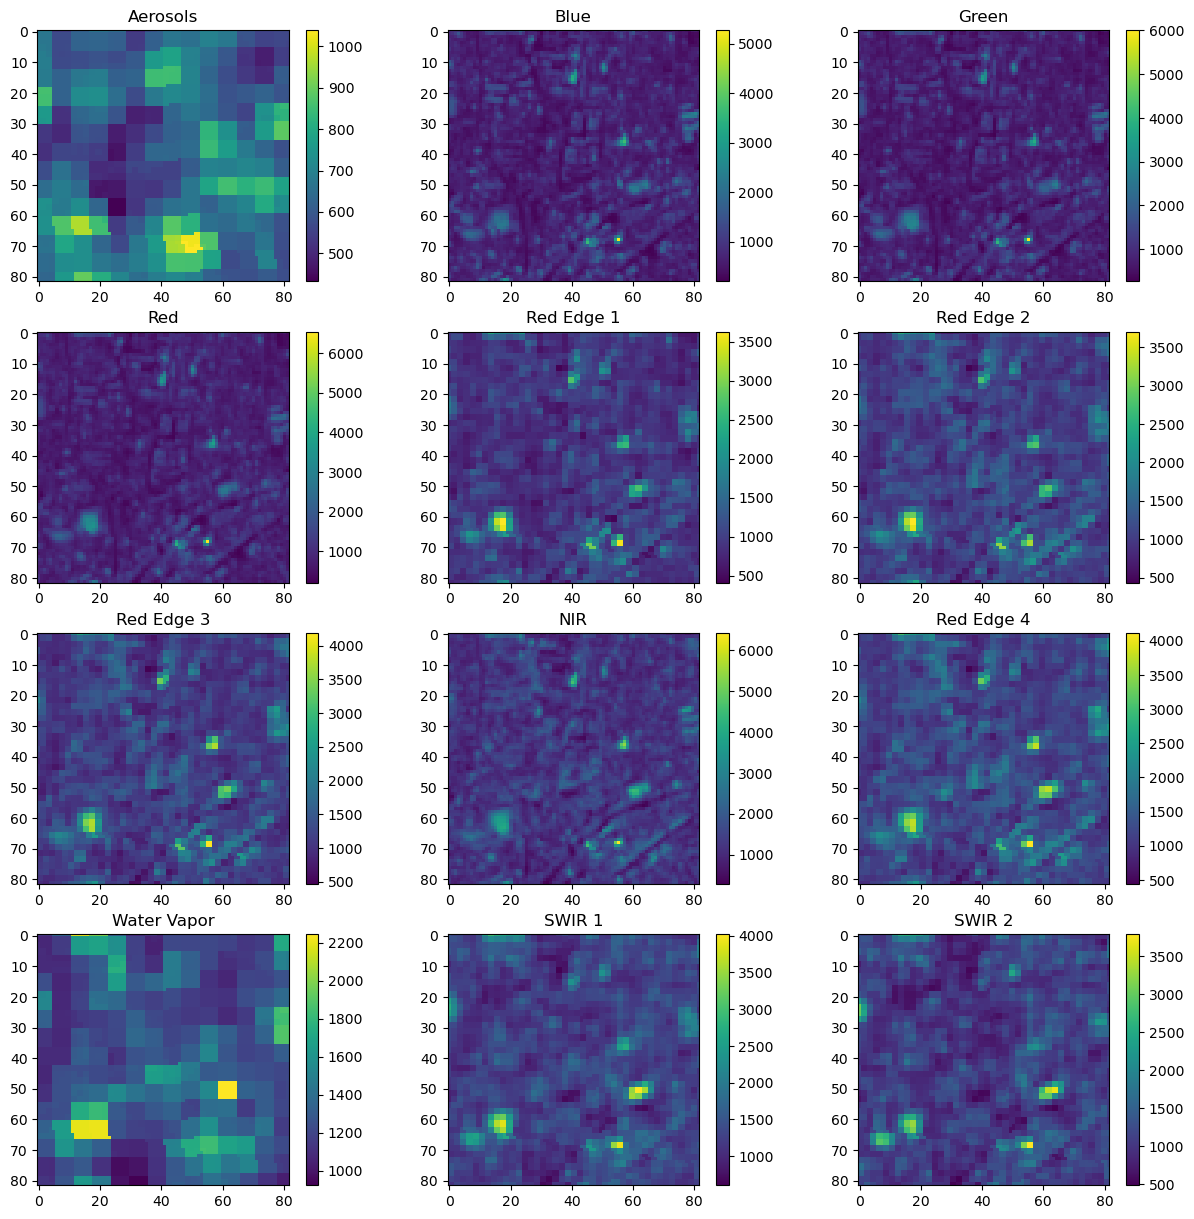

(12, 82, 82)

In [197]:
# Visualise
band_count = 0

bands_dict = {'B1':"Aerosols", 'B2':"Blue", 'B3':"Green", 'B4':"Red", 'B5':"Red Edge 1", 'B6':"Red Edge 2", 'B7':"Red Edge 3", 
                'B8':"NIR", 'B8A':"Red Edge 4", 'B9':"Water Vapor", 'B11':"SWIR 1", 'B12':"SWIR 2"}

fig, axs = plt.subplots(4, 3, figsize= (15, 15))

for col in range(4):
    for row in range(3):
        f = plt.subplot(4, 3, band_count+1)
        f_img = plt.imshow(img_array_cropped[band_count, :, :])
        plt.title(bands_dict[bands_lst[band_count]])
        band_count += 1
        fig.colorbar(f_img, ax= axs[col, row])
    

plt.show()

img_array_cropped.shape

In [198]:
# RGB Image Visualisation
band1 = data_3857.GetRasterBand(1)
band2 = data_3857.GetRasterBand(2)
band3 = data_3857.GetRasterBand(3)


In [199]:
b1 = band1.ReadAsArray()
b2 = band2.ReadAsArray()
b3 = band3.ReadAsArray()

In [200]:
b1.shape

(204, 203)

In [201]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

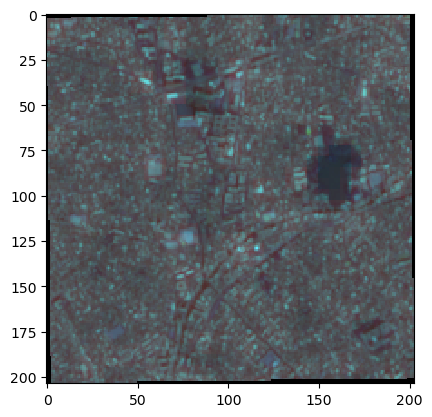

(204, 203, 3)

In [205]:
img = np.dstack((b1, b2, b3))
img *= (255.0/img.max())
f = plt.figure()
img = np.array(img, dtype= "uint8")
img = adjust_gamma(img, 2)
plt.imshow(img, interpolation= "nearest")
# plt.savefig('Tiff.png')
plt.show()
img.shape

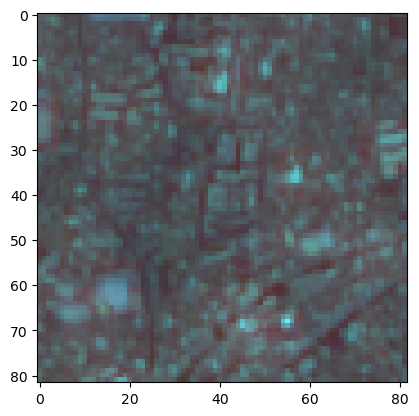

In [203]:
# We can see how reprojecting the image changes the orientation a little
img = np.dstack((b1, b2, b3))
img *= (255.0/img.max())
f = plt.figure()
img = np.array(img, dtype= "uint8")
img = adjust_gamma(img, 2)
plt.imshow(img[center_pt[0]-pixel_buffer:center_pt[0]+pixel_buffer, center_pt[1]-pixel_buffer:center_pt[1]+pixel_buffer, :], interpolation= "nearest")
# plt.imshow(img[500:601, 500:601, :], interpolation= "nearest")

# plt.savefig('Tiff.png')
plt.show()

In [34]:
getBounds(data_3857)

Upper Left Corner: 15543343.063898155 4252071.729937454
Lower Right Corner: 15555805.01404944 4239548.208886213
Width: 12461.950151285157
Height: 12523.521051241085


(15543343.063898155, 4239548.208886213, 15555805.01404944, 4252071.729937454)

In [206]:
# Clear memory
del data
# del data_3857
del img
del img_array

# Plateau Dataset

Since we have a copy already, skip from here

In [207]:
# Read the shape file

plateau_3857 = geopandas.read_file("data/full_Tokyo_plateau/full_Tokyo_plateau.shp")

# Convert the geopandas file to EPSG:3857 projection (metric)
plateau_3857 = plateau_3857.to_crs('EPSG:3857')

In [208]:
plateau_3857.dtypes

height        float64
filestart      object
geometry     geometry
dtype: object

In [209]:
# Check for Nan Values
plateau_3857[plateau_3857["height"].isna()]

,height,filestart,geometry
10437,NaN,53392559,"POLYGON Z ((15555612.806 4238580.074 2.196, 15..."
12221,NaN,53392566,"POLYGON Z ((15552473.729 4239971.703 3.748, 15..."
98334,NaN,53392650,"POLYGON Z ((15557039.673 4238754.864 1.254, 15..."
98361,NaN,53392650,"POLYGON Z ((15557025.575 4238299.834 1.619, 15..."
98364,NaN,53392650,"POLYGON Z ((15557031.209 4238301.282 1.981, 15..."
...,...,...,...
1454961,NaN,53395515,"POLYGON Z ((15550653.076 4267747.211 28.875, 1..."
1551359,NaN,53395543,"POLYGON Z ((15548027.229 4271810.692 3.675, 15..."
1646592,NaN,53395625,"POLYGON Z ((15564360.821 4268835.575 -0.323, 1..."
1664713,NaN,53395631,"POLYGON Z ((15559633.123 4270563.803 2.749, 15..."


In [210]:
# Remove Nan values
plateau_3857 = plateau_3857.dropna().reset_index(drop= True)

# Check for Nan Values
plateau_3857[plateau_3857["height"].isna()]

,height,filestart,geometry


In [211]:
# Save to file
plateau_3857_path = "data/full_Tokyo_plateau/plateau_3857.shp"
plateau_3857.to_file(plateau_3857_path)

In [42]:
# SKIP THIS #
# Rasterises the shape file to a geotiff file
# Sizes
# 1m = 6.1GB
# 0.5m = 24.6GB
# 0.25m = 95.6GB
# Due to very large file sizes, the shape file is first cropped then saved

# target_res = str(0.25) # In georeferenced unit (m)
# shp_path = plateau_3857_path
# suffix = target_res.replace(".", "_")
# dest_path = f"data/full_Tokyo_plateau/plateau_3857_{suffix}m.tiff"
# attribute = "height"
# no_data_val = str(0) #Assign a specified nodata value to output bands.
# output_type = "Float32" 
# override_proj = "EPSG:3857" 
# # Override the projection for the output file. If not specified, the projection of the input vector file will be used if available. 
# # When using this option, no reprojection of features from the SRS of the input vector to the specified SRS of the output raster, so use only this option to correct an invalid source SRS. 
# # The <srs_def> may be any of the usual GDAL/OGR forms, complete WKT, PROJ.4, EPSG:n or a file containing the WKT.

# subprocess.run([
#     "gdal_rasterize", 
#     "-a", attribute, 
#     "-a_nodata", no_data_val, 
#     "-ot", output_type, 
#     "-tr", target_res, target_res, 
#     shp_path, 
#     dest_path, 
#     "-a_srs", "EPSG:3857"])

In [213]:
# Clip the area (based on the sentinel data) we need THEN we rasterize it
min_x, min_y, max_x, max_y = getBounds(data_3857)
plateau_clipped = geopandas.clip(plateau_3857, [min_x, min_y, max_x, max_y]) # Need to create this
plateau_clipped

Upper Left Corner: 15548326.651550282 4247069.106355364
Lower Right Corner: 15550826.430132514 4244557.013592923
Width: 2499.778582232073
Height: 2512.0927624413744


,height,filestart,geometry
150054,26.0,53393504,"POLYGON ((15549247.993 4244557.014, 15549251.5..."
173104,12.1,53393514,"POLYGON Z ((15549280.377 4244596.111 28.840, 1..."
173485,10.0,53393514,"POLYGON Z ((15549238.691 4244623.329 28.361, 1..."
174612,9.5,53393514,"POLYGON Z ((15549267.423 4244632.258 28.019, 1..."
150545,6.3,53393504,"POLYGON Z ((15549207.795 4244559.166 24.533, 1..."
...,...,...,...
248079,11.8,53393534,"POLYGON Z ((15549656.564 4247062.918 37.244, 1..."
246572,10.2,53393534,"POLYGON Z ((15549638.944 4247062.595 36.667, 1..."
244671,9.3,53393534,"POLYGON Z ((15549699.538 4247067.519 36.966, 1..."
246311,9.2,53393534,"POLYGON Z ((15549704.993 4247068.231 36.726, 1..."


In [214]:
# No null values
plateau_clipped[plateau_clipped.isna().any(axis=1)]

,height,filestart,geometry


In [216]:
# Straight up flatten it from 3D to 2D cause we don't need the extra dimension
plateau_clipped_geometry = geopandas.GeoSeries.from_wkb(plateau_clipped.to_wkb(output_dimension= 2)["geometry"])
plateau_clipped_temp = plateau_clipped.drop(["geometry"], axis= 1)
plateau_clipped_temp = geopandas.GeoDataFrame(plateau_clipped_temp, geometry= plateau_clipped_geometry)
# plateau_clipped_temp = plateau_clipped_temp.assign(geometry= plateau_clipped_geometry)
plateau_clipped = plateau_clipped_temp
plateau_clipped

,height,filestart,geometry
150054,26.0,53393504,"POLYGON ((15549247.993 4244557.014, 15549251.5..."
173104,12.1,53393514,"POLYGON ((15549280.377 4244596.111, 15549276.5..."
173485,10.0,53393514,"POLYGON ((15549238.691 4244623.329, 15549238.3..."
174612,9.5,53393514,"POLYGON ((15549267.423 4244632.258, 15549267.7..."
150545,6.3,53393504,"POLYGON ((15549207.795 4244559.166, 15549208.6..."
...,...,...,...
248079,11.8,53393534,"POLYGON ((15549656.564 4247062.918, 15549657.4..."
246572,10.2,53393534,"POLYGON ((15549638.944 4247062.595, 15549640.0..."
244671,9.3,53393534,"POLYGON ((15549699.538 4247067.519, 15549698.6..."
246311,9.2,53393534,"POLYGON ((15549704.993 4247068.231, 15549705.1..."


In [218]:
type(plateau_clipped)

geopandas.geodataframe.GeoDataFrame

In [219]:
type(plateau_clipped["geometry"])

geopandas.geoseries.GeoSeries

In [220]:
plateau_clipped.dtypes

height        float64
filestart      object
geometry     geometry
dtype: object

In [221]:
# Save it to file and name it appropriately
plateau_clipped_output = f"plateau_{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}.shp"

if not os.path.exists(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}"):
    os.makedirs(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}")
plateau_clipped.to_file(f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}/{plateau_clipped_output}")

In [223]:
# Rasterises the shape file to a geotiff file
# Area: 

target_res = str(0.1) # In georeferenced unit (m)
shp_path = f"./data/plateau_cropped/{int(min_x)}_{int(min_y)}_{int(max_x)}_{int(max_y)}/{plateau_clipped_output}"
suffix = target_res.replace(".", "_")
dest_path = f"{os.path.splitext(shp_path)[0]}_{suffix}m.tiff"
attribute = "height"
no_data_val = str(0) #Assign a specified nodata value to output bands.
output_type = "Float32" 
override_proj = "EPSG:3857" 
# Override the projection for the output file. If not specified, the projection of the input vector file will be used if available. 
# When using this option, no reprojection of features from the SRS of the input vector to the specified SRS of the output raster, so use only this option to correct an invalid source SRS. 
# The <srs_def> may be any of the usual GDAL/OGR forms, complete WKT, PROJ.4, EPSG:n or a file containing the WKT.

subprocess.run([
    "gdal_rasterize", 
    "-a", attribute, 
    "-a_nodata", no_data_val, 
    "-ot", output_type, 
    "-tr", target_res, target_res, 
    shp_path, 
    dest_path, 
    "-a_srs", "EPSG:3857"])

0...10...20...30...40...50...60...70...80...90...100 - done.


CompletedProcess(args=['gdal_rasterize', '-a', 'height', '-a_nodata', '0', '-ot', 'Float32', '-tr', '0.1', '0.1', './data/plateau_cropped/15548326_4244557_15550826_4247069/plateau_15548326_4244557_15550826_4247069.shp', './data/plateau_cropped/15548326_4244557_15550826_4247069/plateau_15548326_4244557_15550826_4247069_0_1m.tiff', '-a_srs', 'EPSG:3857'], returncode=0)

In [55]:
# Clear memory
del plateau_3857
del plateau_clipped
del plateau_clipped_temp
del plateau_clipped_geometry

In [225]:
plateau_3857_data = gdal.Open(dest_path, gdal.GA_ReadOnly)
plateau_3857_array = plateau_3857_data.ReadAsArray()
plateau_3857_array.shape

(25122, 24999)

### Resume here

In [226]:
# plateau_3857_data = gdal.Open("data/plateau_cropped/15543343_4239548_15555805_4252071/plateau_15543343_4239548_15555805_4252071_0_25m.tiff", gdal.GA_ReadOnly)
plateau_3857_array = plateau_3857_data.ReadAsArray()
plateau_3857_array.shape

(25122, 24999)

Given high enough resolution, we cannot read the entire tif at once, hence, we should only crop out the area we need from the shape file, then rasterise the portion we need

In [227]:
# Each pixel is 0.1m
plateau_3857_data.GetGeoTransform()

(15548326.601550281, 0.1, 0.0, 4247069.156355364, 0.0, -0.1)

In [228]:
plateau_3857_array

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 7.6, 7.6, ..., 0. , 0. , 0. ],
       [0. , 7.6, 7.6, ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)

## Visualisaing the data, no processing
This is just to ensure that the functions and data are good

In [232]:
# Arbitrarily crop
plateau_3857_array_cropped = plateau_3857_array[:1000, :1000]

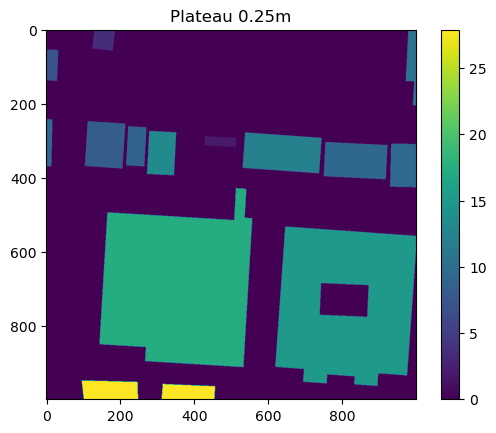

In [233]:
# Visualise
target_res = 0.25
f_img = plt.imshow(plateau_3857_array_cropped) # This needs to be done to not crash the kernel
plt.title(f"Plateau {target_res}m")
fig.colorbar(f_img)

### Calculate the Urban Morphological Parameters

In [234]:
type(plateau_3857_array_cropped)

numpy.ndarray

In [235]:
plateau_3857_array_cropped

array([[ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       [ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       [ 0. ,  0. ,  0. , ..., 10.6, 10.6, 10.6],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ]], dtype=float32)

In [236]:
# Since 0 values are ignored, set them to nan
plateau_3857_array_cropped_nan = plateau_3857_array_cropped.copy()
plateau_3857_array_cropped_nan[plateau_3857_array_cropped_nan == 0] = np.nan

Average Height: 15.233838081359863 m
Average Height (with 0s): 5.748199462890625 m
Maximum Height: 27.899999618530273 m
Maximum Height (with 0s): 27.899999618530273 m
Minimum Height: 2.0 m
Minimum Height (with 0s): 0.0 m
Standard Deviation: 3.8498740196228027 m
Standard Deviation (with 0s): 7.753576278686523 m


(array([  2126.,   3108.,      0.,      0.,      0.,  14906.,   5187.,
         25402.,   3819.,  19824.,      0.,   8453., 129345.,      0.,
        152572.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,  12589.]),
 array([ 2.        ,  3.03600001,  4.07200003,  5.1079998 ,  6.14400005,
         7.17999983,  8.2159996 ,  9.25199986, 10.28800011, 11.3239994 ,
        12.35999966, 13.39599991, 14.43200016, 15.46799946, 16.50399971,
        17.53999901, 18.57600021, 19.61199951, 20.64799881, 21.68400002,
        22.71999931, 23.75600052, 24.79199982, 25.82799911, 26.86400032,
        27.89999962]),
 <BarContainer object of 25 artists>)

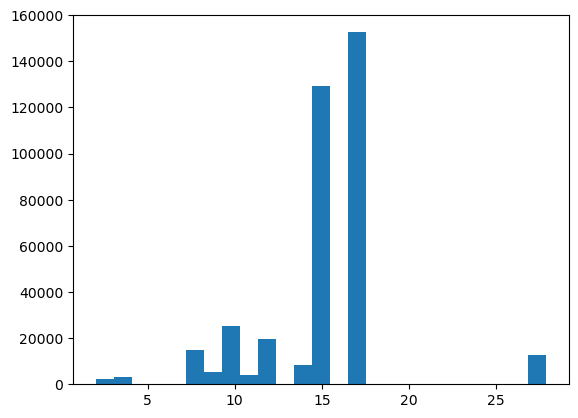

In [237]:
# Find height distribution

# Average Height
print(f"Average Height: {np.nanmean(plateau_3857_array_cropped_nan)} m")
print(f"Average Height (with 0s): {np.mean(plateau_3857_array_cropped)} m")

# Maximum Height
print(f"Maximum Height: {np.nanmax(plateau_3857_array_cropped_nan)} m")
print(f"Maximum Height (with 0s): {np.max(plateau_3857_array_cropped)} m")

# Minimum Height
print(f"Minimum Height: {np.nanmin(plateau_3857_array_cropped_nan)} m")
print(f"Minimum Height (with 0s): {np.min(plateau_3857_array_cropped)} m")

# Standard Deviation
print(f"Standard Deviation: {np.nanstd(plateau_3857_array_cropped_nan)} m")
print(f"Standard Deviation (with 0s): {np.std(plateau_3857_array_cropped)} m")

plt.hist(plateau_3857_array_cropped_nan.flatten(), bins= 25)

In [238]:
# Find total planar area
planar_area = np.sum(plateau_3857_array_cropped > 0) * target_res**2
total_area = plateau_3857_array_cropped.size * target_res**2
print(f"Planar Area: {planar_area} m^2")
print(f"Total Area: {total_area} m^2")

Planar Area: 23583.1875 m^2
Total Area: 62500.0 m^2


In [239]:
# Find total frontal area (Assume North/Top as front)
# Only non-zero pixels with a zero-pixel above it is considered in front facing area calculation
frontal_area = 0
for row in range(1, plateau_3857_array_cropped.shape[0]): # skips the first row as it is extremely unlikely that a building ends right there
    for col in range(plateau_3857_array_cropped.shape[1]):
        val = plateau_3857_array_cropped[row, col]
        if val > 0 and plateau_3857_array_cropped[row-1, col] == 0:
            frontal_area += val*target_res
        
print(f"Frontal Area: {frontal_area} m^2")

Frontal Area: 7823.899848937988 m^2


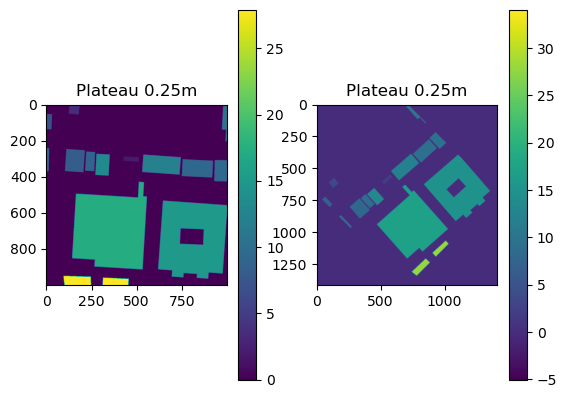

In [240]:
# Test to see if rotation works
plateau_3857_array_cropped_45 = rotate(plateau_3857_array_cropped, 45)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped_45)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)


In [241]:
def calcUMP(arr, percentile= 98, ignore_zero= True, resolution= 0.25):
    """
    Given a 2D numpy array, where the elements represent the height, return the Urban Morphological Parameters in a dictionary\n
    All values are in metres\n
    # Parameters:\n
    arr: 2D numpy array\n
    percentile: The percentile of height to return\n
    ignore_zero: Exclude 0 values (non-buildings) from calculation of UMP\n
    resolution: The resolution of the array in metres\n

    # Returns\n
    AverageHeight\n
    MaximumHeight\n
    MinimumHeight\n
    PercentileHeight\n
    Percentile\n
    StandardDeviation\n
    PlanarArea\n
    FrontalArea\n
    TotalArea\n

    """
    arr_copy = arr.copy()
    if ignore_zero:
        arr_copy[arr_copy == 0] = np.nan
    
    r = {}

    # Average Height
    r["AverageHeight"] = np.nanmean(arr_copy)

    # Maximum Height
    r["MaximumHeight"] = np.nanmax(arr_copy)

    # Minimum Height
    r["MinimumHeight"] = np.nanmin(arr_copy)

    # Percentile Height
    r["PercentileHeight"] = np.nanpercentile(arr_copy, percentile)

    # Percentile for reference
    r["Percentile"] = percentile

    # Standard Deviation
    r["StandardDeviation"] = np.nanstd(arr_copy)

    # Planar Area
    r["PlanarArea"] = np.sum(arr_copy > 0) * resolution**2
    
    # Total Area
    r["TotalArea"] = arr_copy.size * resolution**2

    # Frontal Area
    frontal_area = 0
    for row in range(1, arr.shape[0]): # skips the first row as it is extremely unlikely that a building ends right there
        for col in range(arr.shape[1]):
            val = arr[row, col]
            if val > 0 and arr[row-1, col] == 0:
                frontal_area += val*resolution
    r["FrontalArea"] = frontal_area

    return r

    

In [242]:
print(*calcUMP(plateau_3857_array_cropped).items(), sep= "\n")

('AverageHeight', 15.233838)
('MaximumHeight', 27.9)
('MinimumHeight', 2.0)
('PercentileHeight', 27.899999618530273)
('Percentile', 98)
('StandardDeviation', 3.849874)
('PlanarArea', 23583.1875)
('TotalArea', 62500.0)
('FrontalArea', 7823.899848937988)


In [243]:
# Rotation is iffy
print(*calcUMP(plateau_3857_array_cropped_45).items(), sep= "\n")

('AverageHeight', 7.143047)
('MaximumHeight', 34.04123)
('MinimumHeight', -5.0286436)
('PercentileHeight', 17.309296531677248)
('Percentile', 98)
('StandardDeviation', 8.039014)
('PlanarArea', 36908.0625)
('TotalArea', 124962.25)
('FrontalArea', 783.8142325254609)


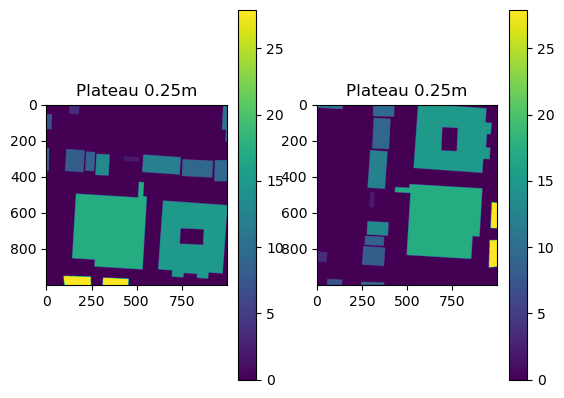

In [244]:
# Trying with 90 degrees instead
# Test to see if rotation works
plateau_3857_array_cropped_90 = rotate(plateau_3857_array_cropped, 90)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped_90)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)

In [245]:
print("Default:")
print(*calcUMP(plateau_3857_array_cropped).items(), sep= "\n")
print()
# Still iffy
print("90 Degrees:")
print(*calcUMP(plateau_3857_array_cropped_90).items(), sep= "\n")

Default:
('AverageHeight', 15.233838)
('MaximumHeight', 27.9)
('MinimumHeight', 2.0)
('PercentileHeight', 27.899999618530273)
('Percentile', 98)
('StandardDeviation', 3.849874)
('PlanarArea', 23583.1875)
('TotalArea', 62500.0)
('FrontalArea', 7823.899848937988)

90 Degrees:
('AverageHeight', 8.046198)
('MaximumHeight', 27.9)
('MinimumHeight', -1.9841275e-15)
('PercentileHeight', 17.299999237060547)
('Percentile', 98)
('StandardDeviation', 8.103184)
('PlanarArea', 34463.5)
('TotalArea', 62500.0)
('FrontalArea', 1.7463682111648033e-42)


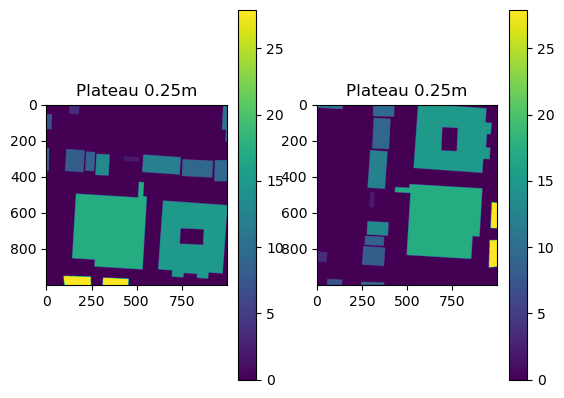

In [246]:
# Trying with np's 90 degrees instead
# Test to see if rotation works
plateau_3857_array_cropped_90_np = np.rot90(plateau_3857_array_cropped)
# Visualise
fig, ax = plt.subplots(1, 2)
plt.subplot(1, 2, 1) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)
plt.subplot(1, 2, 2) # This needs to be done to not crash the kernel
f = plt.imshow(plateau_3857_array_cropped_90_np)
plt.title(f"Plateau {target_res}m")
fig.colorbar(f)

In [247]:
print("Default:")
print(*calcUMP(plateau_3857_array_cropped).items(), sep= "\n")
print()
# Consistent
print("90 Degrees:")
print(*calcUMP(plateau_3857_array_cropped_90_np).items(), sep= "\n")

Default:
('AverageHeight', 15.233838)
('MaximumHeight', 27.9)
('MinimumHeight', 2.0)
('PercentileHeight', 27.899999618530273)
('Percentile', 98)
('StandardDeviation', 3.849874)
('PlanarArea', 23583.1875)
('TotalArea', 62500.0)
('FrontalArea', 7823.899848937988)

90 Degrees:
('AverageHeight', 15.2338295)
('MaximumHeight', 27.9)
('MinimumHeight', 2.0)
('PercentileHeight', 27.899999618530273)
('Percentile', 98)
('StandardDeviation', 3.8498747)
('PlanarArea', 23583.1875)
('TotalArea', 62500.0)
('FrontalArea', 6718.899849057198)


# Merge Sentinel and Plateau

In [250]:
file_list = [dest_path, output_raster]

# Read metadata of first file
with rio.open(file_list[0]) as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rio.open('stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(layer) as src1:
            dst.write_band(id, src1.read(1))

In [56]:
# Obtain the bounds of each
data_3857 = gdal.Open(output_raster, gdal.GA_ReadOnly)

print("Sentinel:")
getBounds(data_3857)
# This will be the resultant file
corr_arr = data_3857.ReadAsArray().copy()
print(corr_arr.shape)
print()
print("Plateau:")
getBounds(plateau_3857_data)
print(plateau_3857_array.shape)

Sentinel:
Upper Left Corner: 15543343.063898155 4252071.729937454
Lower Right Corner: 15555805.01404944 4239548.208886213
Width: 12461.950151285157
Height: 12523.521051241085
(12, 1017, 1012)

Plateau:
Upper Left Corner: 15543342.938898155 4252071.854937454
Lower Right Corner: 15555805.188898155 4239548.104937454
Width: 12462.25
Height: 12523.75
(50095, 49849)


In [58]:
pixel_width = data_3857.GetGeoTransform()[1]
print("Sentinel Pixel Width:", pixel_width)

Sentinel Pixel Width: 12.314179991387709


In [59]:
def boundingRectangle(center, width, height):
    min_x = center[0] - width
    min_y = center[1] - height
    max_x = center[0] - width
    max_y = center[1] - height
    return [min_x, min_y, max_x, max_y]

In [145]:
# Crop out each grid of the plateau dataset, calculate the parameters then add it into the grid
pixel_coords = getCoordinates(data_3857, 0, 0)

(15543343.063898155, 4252071.729937454)

In [ ]:
rect = boundingRectangle(pixel_coords, pixel_width, pixel_width)
getPixel()

sample_grid = plateau_3857_array[]

# LandScan Dataset: Population

In [18]:
landscan_data = gdal.Open("data/landscan-global-2021-assets/landscan-global-2021-colorized.tif", gdal.GA_ReadOnly)
landscan_array = landscan_data.ReadAsArray()
landscan_array.shape

(4, 21600, 43200)

(4, 21600, 43200)

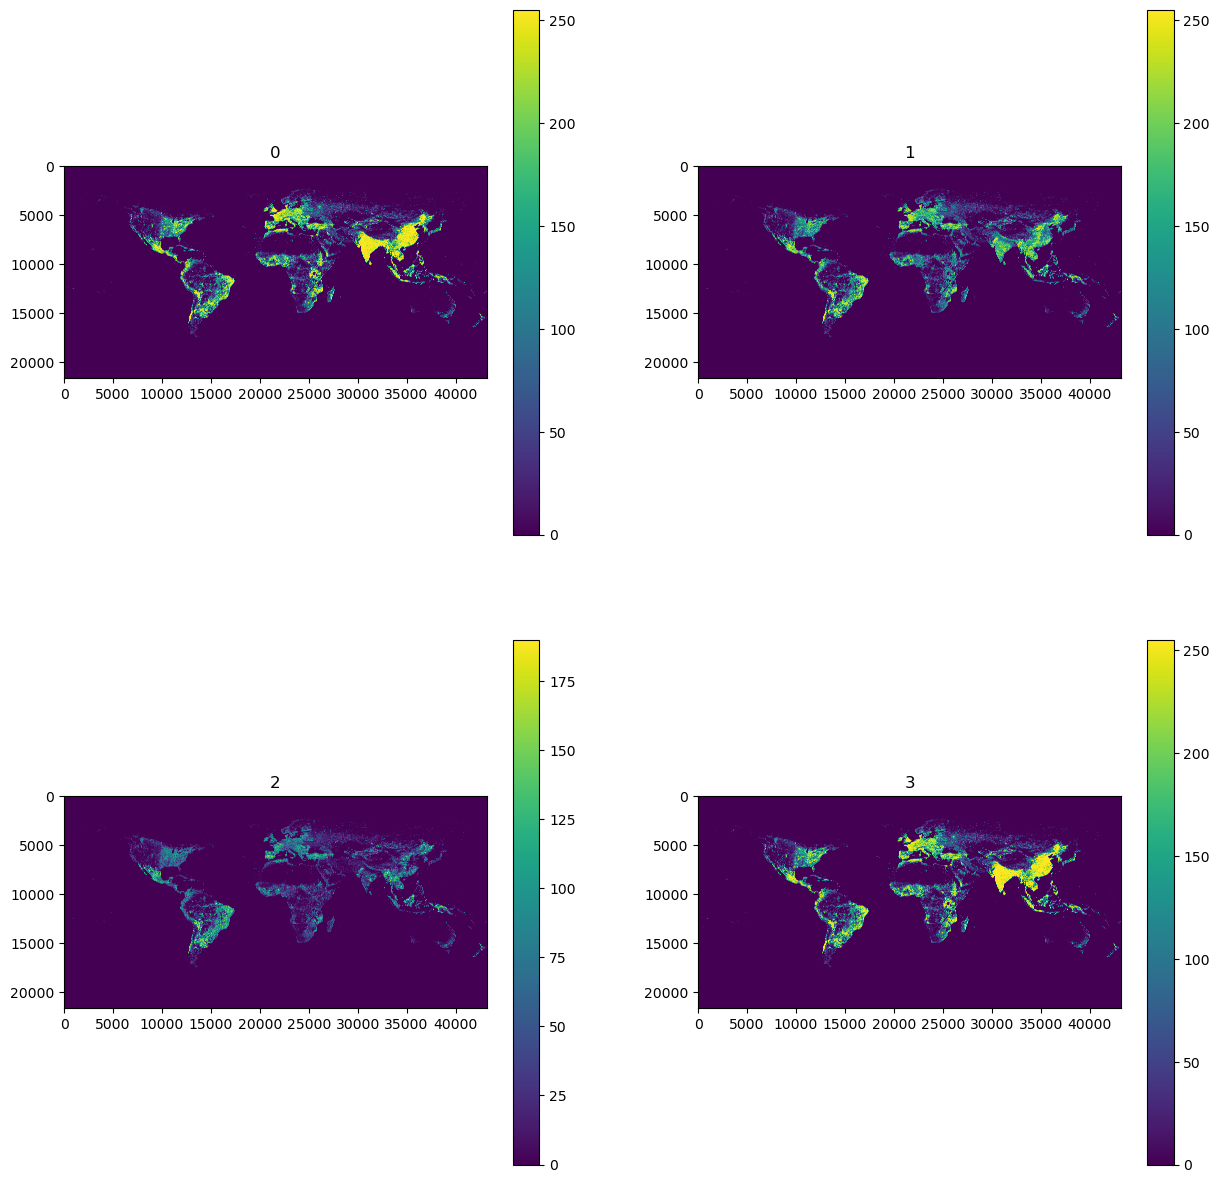

In [19]:
# Visualise
band_count = 0

fig, axs = plt.subplots(2, 2, figsize= (15, 15))

for col in range(2):
    for row in range(2):
        f = plt.subplot(2, 2, band_count+1)
        f_img = plt.imshow(landscan_array[band_count, :, :])
        plt.title(band_count)
        band_count += 1
        fig.colorbar(f_img, ax= axs[col, row])

In [20]:
landscan_single_data = gdal.Open("data/landscan-global-2021-assets/landscan-global-2021.tif", gdal.GA_ReadOnly)
landscan_single_array = landscan_single_data.ReadAsArray()
landscan_single_array.shape

(21600, 43200)

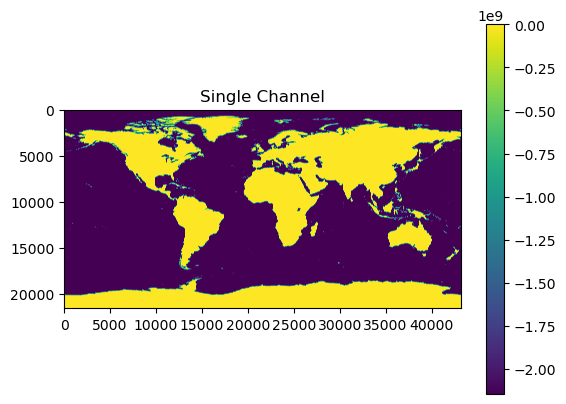

In [22]:
# Visualise
f_img = plt.imshow(landscan_single_array)
plt.title("Single Channel")
fig.colorbar(f_img)

In [24]:
# landscan_local = ee.Image("projects/ee-lqchan-1/assets/landscan-global-2021")
# Map.addLayer(landscan_local, {"min": 0, "max": 185000}, "landscan_local")

In [25]:
# Get the landscan data set and print out some details
# https://gee-community-catalog.org/projects/landscan/ 
landscan = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")
landscan_bands_lst = landscan.first().bandNames().getInfo()
landscan_size = landscan.size().getInfo()
print(f"Landscan Bands: {landscan_bands_lst}")
print(f"Number of images in collection: {landscan_size}")

Landscan Bands: ['b1']
Number of images in collection: 22


In [26]:
print("### Image Properties ###")
print(sorted(landscan.first().propertyNames().getInfo()))

### Image Properties ###
['id_no', 'num_bands', 'system:asset_size', 'system:band_names', 'system:bands', 'system:footprint', 'system:id', 'system:index', 'system:time_end', 'system:time_start', 'system:version', 'xsize', 'ysize']


In [27]:
# Retrieve dates of image
print(*ds.getDates(landscan), sep= "\n")

2000/01/01 10:30
2001/01/01 10:30
2002/01/01 10:30
2003/01/01 10:30
2004/01/01 10:30
2005/01/01 10:30
2006/01/01 10:30
2007/01/01 10:30
2008/01/01 10:30
2009/01/01 10:30
2010/01/01 10:30
2011/01/01 10:30
2012/01/01 10:30
2013/01/01 10:30
2014/01/01 10:30
2015/01/01 10:30
2016/01/01 10:30
2017/01/01 10:30
2018/01/01 10:30
2019/01/01 10:30
2020/01/01 10:30
2021/01/01 10:30


In [43]:
# Display landscan_Image Metadata
# Display all metadata.
landscan_image = landscan.first()
# print('All metadata:', landscan_image)

# Get information about the bands as a list.
bandNames = landscan_image.bandNames().getInfo()
print('Band names:', bandNames)  # ee.List of band names

# Get projection information from band 1.
b1proj = landscan_image.select('b1').projection().getInfo()
print('Band 1 projection:', b1proj)  # ee.Projection object

# Get scale (in meters) information from band 1.
b1scale = landscan_image.select('b1').projection().nominalScale().getInfo()
print('Band 1 scale:', b1scale)  # ee.Number

# Get a list of all metadata properties.
properties = landscan_image.propertyNames().getInfo()
print('Metadata properties:', properties)  # ee.List of metadata properties

# Get version number (ingestion timestamp as microseconds since Unix epoch).
version = landscan_image.get('system:version').getInfo()
print('Version:', version)  # ee.Number
print('Version (as ingestion date):',
      ee.Date(ee.Number(version).divide(1000)).getInfo())  # ee.Date

# Get the timestamp and convert it to a date.
date = ee.Date(landscan_image.get('system:time_start')).getInfo()
print('Timestamp:', date)  # ee.Date

Band names: ['b1']
Band 1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}
Band 1 scale: 927.662423277276
Metadata properties: ['system:time_start', 'num_bands', 'id_no', 'ysize', 'system:footprint', 'system:time_end', 'system:version', 'xsize', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
Version: 1664042032746763
Version (as ingestion date): {'type': 'Date', 'value': 1664042032746}
Timestamp: {'type': 'Date', 'value': 946690200000}


In [44]:
landscan_image_min = landscan_image.select("b1").get("min").getInfo()
print(landscan_image_min)

None


In [45]:
# Get min and max values from band 1
minmax = landscan_image.select("b1").min(landscan_image).getInfo(), landscan_image.select("b1").max(landscan_image).getInfo()
print(f"Band 1 Range: {minmax}")

Band 1 Range: ({'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}]}, {'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:4326', 'crs_transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 85.99999999999929]}]})


In [30]:
Map

Map(center=[35.60069037543433, 139.6842362073651], controls=(WidgetControl(options=['position', 'transparent_b…

In [28]:
Map.addLayer(landscan.first(), {"min": 0, "max": 185000}, "landscan")

# Merging the Datasets

Currently, we are doing year 2021, as that is the latest image available from landscan dataset. One thing to note is that it is 2021/01/01, so perhaps it's better to treat it as 2020? 

In [29]:
# The median from S2HR 2021
s2HR_2021 = ds.filterCollection(s2HR, [2021], "Y_S")
s2HR_2021_cloudless = ds.remove_clouds(s2HR_2021)
s2HR_2021_median = s2HR_2021_cloudless.median()

In [30]:
# The landscan from 2021
landscan_2021 = ds.filterCollection(landscan, [2021], "Y_S")
print(ds.getDates(landscan_2021))
landscan_2021 = landscan_2021.first()
landscan_2021 = landscan_2021.toDouble()
landscan_2021.bandTypes().getInfo()

['2021/01/01 10:30']


{'b1': {'type': 'PixelType', 'precision': 'double'}}

In [31]:
ds.getInfo(s2HR_2021_median)

Band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
Band: B1
B1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B1 scale: 111319.49079327357
Band: B2
B2 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B2 scale: 111319.49079327357
Band: B3
B3 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B3 scale: 111319.49079327357
Band: B4
B4 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B4 scale: 111319.49079327357
Band: B5
B5 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B5 scale: 111319.49079327357
Band: B6
B6 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B6 scale: 111319.49079327357
Band: B7
B7 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B7 scale: 111319.49079327357
Band: B8


In [32]:
ds.getInfo(landscan_2021)

Band names: ['b1']
Band: b1
b1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [0.0083333333333333, 0, -180, 0, -0.0083333333333333, 89.99999999999929]}
b1 scale: 927.662423277276
Metadata properties: ['system:time_start', 'num_bands', 'id_no', 'ysize', 'system:footprint', 'system:time_end', 'system:version', 'xsize', 'system:id', 'system:asset_size', 'system:index', 'system:bands', 'system:band_names']
DateTime: 2021/01/01 10:30


In [33]:
# Combined Image Collection
combined_img = s2HR_2021_median.addBands(landscan_2021)
ds.getInfo(combined_img)


Band names: ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'b1']
Band: B1
B1 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B1 scale: 111319.49079327357
Band: B2
B2 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B2 scale: 111319.49079327357
Band: B3
B3 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B3 scale: 111319.49079327357
Band: B4
B4 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B4 scale: 111319.49079327357
Band: B5
B5 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B5 scale: 111319.49079327357
Band: B6
B6 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B6 scale: 111319.49079327357
Band: B7
B7 projection: {'type': 'Projection', 'crs': 'EPSG:4326', 'transform': [1, 0, 0, 0, 1, 0]}
B7 scale: 111319.49079327357
Ban

In [68]:
# Get scale (in meters) information from band 1.
b1scale = s2HR.median().select("B2").projection().nominalScale().getInfo()
print(f'scale:', b1scale)  # ee.Number

scale: 111319.49079327357


What we want to do currently:
1. Combine the datasets into a single image
2. Have a fixed grid system (geometry bounds starting from a certain point, for now use landscan as reference)
3. For each bound, plot the RBG of the sentinel as well as return a value for the population

In [57]:
# # Filter Image by bounds
# combined_img_filtered = combined_img.clip(ds.boundingRectangle(CITY, 10000, 10000, "EPSG:4326"))

# # Cast all to float
# combined_img_filtered = combined_img_filtered.toFloat()



In [58]:
# Map.addLayer(combined_img_filtered)

In [34]:
ds.exportImageToDrive(combined_img, CITY, [1000, 1000], "Landscan", projection= combined_img.select("B2").projection().getInfo(), prefix= "LandScan")

<Task OMFG2DXZZGBZFWCIRVXFFFCC EXPORT_IMAGE: LandScan_UNKNOWN_DT (UNSUBMITTED)>

In [63]:
combined_img.bandTypes().getInfo()

{'B1': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B11': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B12': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B2': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B3': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B4': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B5': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B6': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B7': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B8': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B8A': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'B9': {'type': 'PixelType', 'precision': 'double', 'min': 0, 'max': 65535},
 'b1': {'type': 'PixelType',
  'precision': 'int',
  'min': -2147483648,


In [ ]:
print('Multi-band GeoTIFF file',
  combined_img.getDownloadURL({
    "bands": ['B3', 'B8', 'B11'],
    "region": ds.boundingRectangle(CITY, 100, 100, combined_img.select("B2").projection().getInfo()),
    "scale": 10,
    format: 'GEO_TIFF'
  }))